This sheet is a companion to the Yield Modeling Tools Workshop background talk on  Completeness, Integration Time, and $\Delta$mag.  The code here reproduces the figures used in the talk, and provides additional, interactive plots.

In [1]:
# import all of the packages we're going to use
import copy
from EXOSIMS.Prototypes.TargetList import TargetList
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import warnings
from matplotlib import ticker
import matplotlib.colors
import scipy
import ipywidgets as widgets

In [2]:
# set up plotting
%matplotlib widget
plt.rcParams.update({'figure.max_open_warning': 0})

We're going to construct a basic EXOSISM `TargetList` object, which will automatically build up all of the components we need for computing completeness and associated values.

In [3]:
# Build a basic target list and compute completeness PDF
specs0 = {
    "ppFact": 0.1,
    "minComp": 0,
    "IWA": 0.05,
    "OWA": 0.25,
    "Nplanets": 1e9,
    "filterBinaries": False,
    "keepStarCatalog": True,
    "constrainOrbits": False,
    "erange": [0, 0.35],
    "modules": {
        "PlanetPopulation": "EarthTwinHabZone2",
        "StarCatalog": "HWOMissionStars",
        "OpticalSystem": " ",
        "ZodiacalLight": " ",
        "BackgroundSources": " ",
        "PlanetPhysicalModel": " ",
        "Observatory": " ",
        "TimeKeeping": " ",
        "PostProcessing": " ",
        "Completeness": "BrownCompleteness",
        "TargetList": " ",
        "SimulatedUniverse": " ",
        "SurveySimulation": " ",
        "SurveyEnsemble": " ",
    },
}

TL = TargetList(**copy.deepcopy(specs0), explainFiltering=True)

Imported HWOMissionStars (implementation) from EXOSIMS.StarCatalog.HWOMissionStars
Loaded data from /Users/ds264/.EXOSIMS/downloads/HWOStarList_20240526125022.pkl
Imported OpticalSystem (prototype) from EXOSIMS.Prototypes.OpticalSystem
Imported ZodiacalLight (prototype) from EXOSIMS.Prototypes.ZodiacalLight
Imported PostProcessing (prototype) from EXOSIMS.Prototypes.PostProcessing
Imported BackgroundSources (prototype) from EXOSIMS.Prototypes.BackgroundSources
Imported BrownCompleteness (implementation) from EXOSIMS.Completeness.BrownCompleteness
Imported EarthTwinHabZone2 (implementation) from EXOSIMS.PlanetPopulation.EarthTwinHabZone2
Imported PlanetPhysicalModel (prototype) from EXOSIMS.Prototypes.PlanetPhysicalModel
Loading cached completeness file from "/Users/ds264/.EXOSIMS/cache/EarthTwinHabZone2PlanetPhysicalModelBrownCompleteness1000000000lambertf7d64e15d6ee911aaea8a2d05b616b47.comp".
Completeness loaded from cache.
164 targets imported from star catalog.
164 targets remain af

For our generated joint PDF of projected separation and $\Delta$mag we can compute upper and lower bounds, as well as the curve at quadrature:

In [4]:
# compute dmag limits
s = TL.Completeness.xnew
dmagmax = -2.5 * np.log10(
    TL.PlanetPopulation.prange.min()
    * (
        (TL.PlanetPopulation.Rprange.min() / TL.PlanetPopulation.rrange.max())
        .decompose()
        .value
    )
    ** 2
    * TL.PlanetPhysicalModel.calc_Phi(
        (np.pi - np.arcsin(s / TL.PlanetPopulation.rrange.max().value)) * u.rad
    )
)

betastarexpr = (
    lambda beta: -(np.pi - beta) * np.sin(beta) ** 3 / np.pi
    + 2
    * ((np.pi - beta) * np.cos(beta) + np.sin(beta))
    * np.sin(beta)
    * np.cos(beta)
    / np.pi
)
betastar = scipy.optimize.fsolve(betastarexpr, 63 * np.pi / 180)[0]

bp1 = TL.PlanetPopulation.rrange.min().value * np.sin(betastar)
bp2 = TL.PlanetPopulation.rrange.max().value * np.sin(betastar)
dmagmin = np.zeros(s.size)
dmagmin[s < bp1] = -2.5 * np.log10(
    TL.PlanetPopulation.prange.max()
    * (
        (TL.PlanetPopulation.Rprange.max() / TL.PlanetPopulation.rrange.min())
        .decompose()
        .value
    )
    ** 2
    * TL.PlanetPhysicalModel.calc_Phi(
        (np.arcsin(s[s < bp1] / TL.PlanetPopulation.rrange.min().value)) * u.rad
    )
)
inds = (s >= bp1) & (s < bp2)
dmagmin[inds] = -2.5 * np.log10(
    TL.PlanetPopulation.prange.max()
    * ((TL.PlanetPopulation.Rprange.max().to(u.AU).value / s[inds])) ** 2
    * TL.PlanetPhysicalModel.calc_Phi(betastar * u.rad)
    * np.sin(betastar) ** 2
)
dmagmin[s >= bp2] = -2.5 * np.log10(
    TL.PlanetPopulation.prange.max()
    * (
        (TL.PlanetPopulation.Rprange.max() / TL.PlanetPopulation.rrange.max())
        .decompose()
        .value
    )
    ** 2
    * TL.PlanetPhysicalModel.calc_Phi(
        (np.arcsin(s[s >= bp2] / TL.PlanetPopulation.rrange.max().value)) * u.rad
    )
)
dmag90 = -2.5 * np.log10(
    TL.PlanetPopulation.prange.max()
    * ((TL.PlanetPopulation.Rprange.max().to(u.AU).value / s)) ** 2
    * TL.PlanetPhysicalModel.calc_Phi(np.pi / 2 * u.rad)
    * np.sin(np.pi / 2) ** 2
)

/var/folders/m2/11pg8ytd2b32gg02912yvzzm0000gn/T/ipykernel_78636/51502066.py:62: RuntimeWarning: divide by zero encountered in divide
  * ((TL.PlanetPopulation.Rprange.max().to(u.AU).value / s)) ** 2


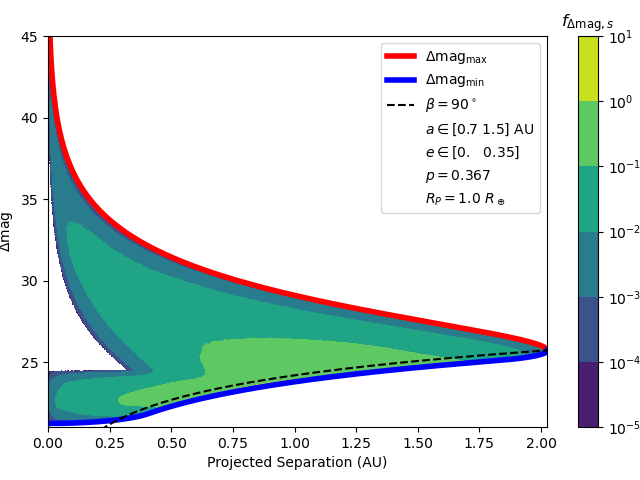

In [5]:
# Generate annotated completeness plot
fig = plt.figure()
ax = fig.add_subplot(111)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cs = ax.contourf(
        TL.Completeness.xnew,
        TL.Completeness.ynew,
        TL.Completeness.Cpdf,
        locator=ticker.LogLocator(),
    )
ax.set_xlabel("Projected Separation (AU)")
ax.set_ylabel("$\Delta$mag")
cbar = fig.colorbar(cs)
cbar.ax.set_title("$f_{\Delta\\mathrm{mag},s}$")
ylim = [21, 45]
ax.set_ylim(ylim)
plt.subplots_adjust(top=0.925, left=0.075, right=1.05)
plt.plot(s, dmagmax, "r", linewidth=4, label="$\\Delta\\mathrm{mag}_\\mathrm{max}$")
plt.plot(s, dmagmin, "b", linewidth=4, label="$\\Delta\\mathrm{mag}_\\mathrm{min}$")
plt.plot(s, dmag90, "k--", label="$\\beta = 90^\\circ$")
ax.plot(0, 0, label=f"$a \in ${TL.PlanetPopulation.arange}", visible=False)
ax.plot(0, 0, label=f"$e \in ${TL.PlanetPopulation.erange}", visible=False)
ax.plot(0, 0, label=f"$p = ${TL.PlanetPopulation.prange[0]}", visible=False)
ax.plot(
    0,
    0,
    label=f"$R_P = ${TL.PlanetPopulation.Rprange[0].value} $R_\\oplus$",
    visible=False,
)
plt.legend();

The figure above is the joint PDF for the selected (vaguely Earth-like) planet population. To this, we can add the instrumental bounds and compute completeness:

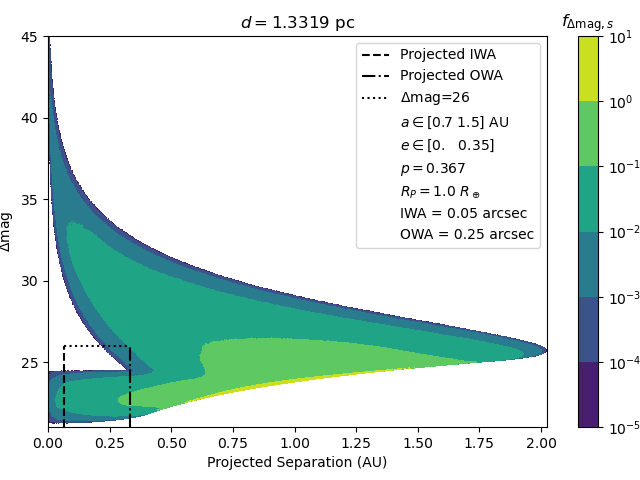

In [6]:
# show instrument limits for nearest star
fig = plt.figure()
ax = fig.add_subplot(111)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cs = ax.contourf(
        TL.Completeness.xnew,
        TL.Completeness.ynew,
        TL.Completeness.Cpdf,
        locator=ticker.LogLocator(),
    )
ax.set_xlabel("Projected Separation (AU)")
ax.set_ylabel("$\Delta$mag")
cbar = fig.colorbar(cs)
cbar.ax.set_title("$f_{\Delta\\mathrm{mag},s}$")
ax.set_ylim(ylim)
plt.subplots_adjust(top=0.925, left=0.075, right=1.05)
mode = TL.OpticalSystem.observingModes[0]

sInd = np.argmin(TL.dist)
projIWA = (np.tan(mode["IWA"]) * TL.dist[sInd]).to(u.AU)
projOWA = (np.tan(mode["OWA"]) * TL.dist[sInd]).to(u.AU)
ax.plot([projIWA.value] * 2, [ylim[0], 26], "k--", label="Projected IWA")
ax.plot([projOWA.value] * 2, [ylim[0], 26], "k-.", label="Projected OWA")
ax.plot([projIWA.value, projOWA.value], [26] * 2, "k:", label="$\\Delta$mag=26")
ax.plot(0, 0, label=f"$a \in ${TL.PlanetPopulation.arange}", visible=False)
ax.plot(0, 0, label=f"$e \in ${TL.PlanetPopulation.erange}", visible=False)
ax.plot(0, 0, label=f"$p = ${TL.PlanetPopulation.prange[0]}", visible=False)
ax.plot(
    0,
    0,
    label=f"$R_P = ${TL.PlanetPopulation.Rprange[0].value} $R_\\oplus$",
    visible=False,
)
ax.plot(0, 0, label=f"IWA = {TL.OpticalSystem.IWA}", visible=False)
ax.plot(0, 0, label=f"OWA = {TL.OpticalSystem.OWA}", visible=False)
plt.legend()
ax.set_title(f"$d = ${TL.dist[sInd]}");

We can now show how the projected IWA/OWA and completeness scale with stellar distance: 

interactive(children=(IntSlider(value=0, description='j', max=39), Output()), _dom_classes=('widget-interact',…

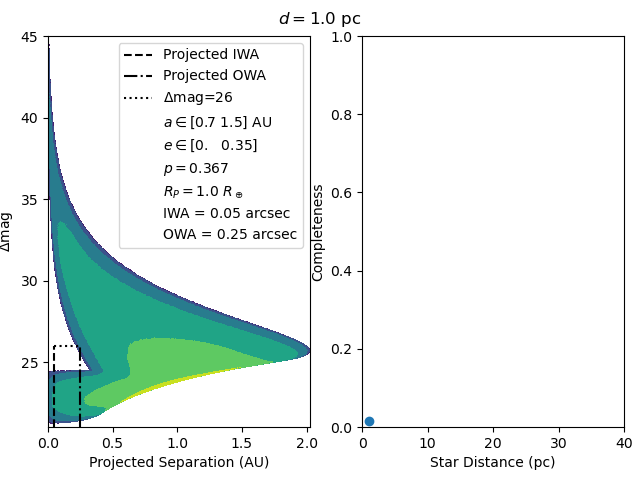

In [7]:
dists = np.arange(1, 41) * u.pc
smins = (np.tan(mode["IWA"]) * dists).to(u.AU)
smaxs = (np.tan(mode["OWA"]) * dists).to(u.AU)
comps = TL.Completeness.comp_calc(smins.value, smaxs.value, 26)

fig, axs = plt.subplots(1, 2)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cs = axs[0].contourf(
        TL.Completeness.xnew,
        TL.Completeness.ynew,
        TL.Completeness.Cpdf,
        locator=ticker.LogLocator(),
    )
axs[0].set_xlabel("Projected Separation (AU)")
axs[0].set_ylabel("$\Delta$mag")
pIWA = axs[0].plot([smins[0].value] * 2, [ylim[0], 26], "k--", label="Projected IWA")[0]
pOWA = axs[0].plot([smaxs[0].value] * 2, [ylim[0], 26], "k-.", label="Projected OWA")[0]
dmaglim = axs[0].plot(
    [smins[0].value, smaxs[0].value], [26] * 2, "k:", label="$\\Delta$mag=26"
)[0]
axs[0].plot(0, 0, label=f"$a \in ${TL.PlanetPopulation.arange}", visible=False)
axs[0].plot(0, 0, label=f"$e \in ${TL.PlanetPopulation.erange}", visible=False)
axs[0].plot(0, 0, label=f"$p = ${TL.PlanetPopulation.prange[0]}", visible=False)
axs[0].plot(
    0,
    0,
    label=f"$R_P = ${TL.PlanetPopulation.Rprange[0].value} $R_\\oplus$",
    visible=False,
)
axs[0].plot(0, 0, label=f"IWA = {TL.OpticalSystem.IWA}", visible=False)
axs[0].plot(0, 0, label=f"OWA = {TL.OpticalSystem.OWA}", visible=False)
axs[0].legend()
axs[0].set_ylim(ylim)
xlim0 = axs[0].get_xlim()
fig.suptitle(f"$d = ${dists[0]}")

compline = axs[1].plot(dists[0], comps[0])[0]
comppoint = axs[1].scatter(dists[0], comps[0])
axs[1].set_xlim([0, 40])
axs[1].set_ylim([0, 1])
axs[1].set_xlabel("Star Distance (pc)")
axs[1].set_ylabel("Completeness")

plt.subplots_adjust(top=0.925, left=0.075, right=0.975)

def drawCompFrame(j):
    pIWA.set_data([smins[j].value] * 2, [ylim[0], 26])
    pOWA.set_data([smaxs[j].value] * 2, [ylim[0], 26])
    dmaglim.set_data([smins[j].value, smaxs[j].value], [26] * 2)
    if smaxs[j].value > TL.Completeness.xnew.max():
        axs[0].set_xlim([0, smaxs[j].value])
    else:
        axs[0].set_xlim(xlim0)
    fig.suptitle(f"$d = ${dists[j]}")
    compline.set_data(dists[: j + 1], comps[: j + 1])
    comppoint.set_offsets((dists[j].value, comps[j]))
    
widgets.interact(drawCompFrame, j=widgets.IntSlider(min=0, max=len(dists)-1, step=1, value=0));
# use slider to change the star distance

Next, we can explore the dependence of all of the values on stellar luminosity, in the case where we are scaling the orbits to match solar insolation:

interactive(children=(IntSlider(value=0, description='j', max=39), Output()), _dom_classes=('widget-interact',…

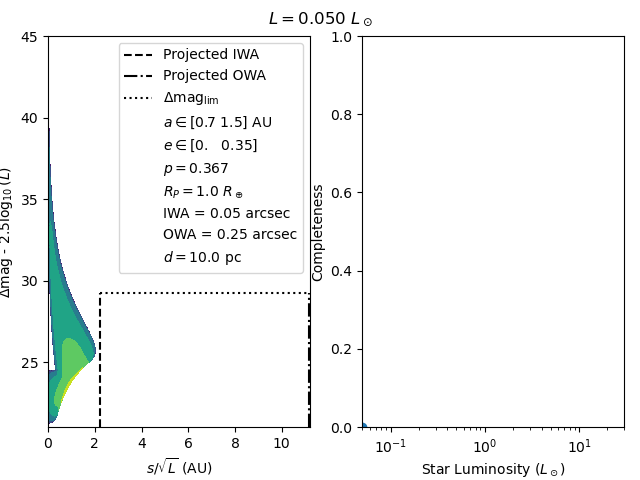

In [8]:
d = 10 * u.pc
# Ls = np.hstack((np.arange(0.1, 1, 0.1), np.arange(1, 11, 1)))
Ls = np.logspace(np.log10(0.05), np.log10(30), 40)
L1ind = np.argmin(np.abs(Ls - 10))
smins2 = (np.tan(mode["IWA"]) * d).to(u.AU) / np.sqrt(Ls)
smaxs2 = (np.tan(mode["OWA"]) * d).to(u.AU) / np.sqrt(Ls)
dmags2 = 26 - 2.5 * np.log10(Ls)
comps2 = TL.Completeness.comp_calc(smins2.value, smaxs2.value, dmags2)

fig2, axs2 = plt.subplots(1, 2)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cs = axs2[0].contourf(
        TL.Completeness.xnew,
        TL.Completeness.ynew,
        TL.Completeness.Cpdf,
        locator=ticker.LogLocator(),
    )
axs2[0].set_xlabel("$s/\sqrt{L}$ (AU)")
axs2[0].set_ylabel("$\Delta$mag - 2.5$\log_{10}(L)$")
pIWA2 = axs2[0].plot([smins2[0].value] * 2, [ylim[0], dmags2[0]], "k--", label="Projected IWA")[0]
pOWA2 = axs2[0].plot([smaxs2[0].value] * 2, [ylim[0], dmags2[0]], "k-.", label="Projected OWA")[0]
dmaglim2 = axs2[0].plot(
    [smins2[0].value, smaxs2[0].value], [dmags2[0]] * 2, "k:", label="$\\Delta$mag$_\\mathrm{lim}$"
)[0]
axs2[0].plot(0, 0, label=f"$a \in ${TL.PlanetPopulation.arange}", visible=False)
axs2[0].plot(0, 0, label=f"$e \in ${TL.PlanetPopulation.erange}", visible=False)
axs2[0].plot(0, 0, label=f"$p = ${TL.PlanetPopulation.prange[0]}", visible=False)
axs2[0].plot(
    0,
    0,
    label=f"$R_P = ${TL.PlanetPopulation.Rprange[0].value} $R_\\oplus$",
    visible=False,
)
axs2[0].plot(0, 0, label=f"IWA = {TL.OpticalSystem.IWA}", visible=False)
axs2[0].plot(0, 0, label=f"OWA = {TL.OpticalSystem.OWA}", visible=False)
axs2[0].plot(0, 0, label=f"$d = ${d}", visible=False)
axs2[0].legend(loc=1)
axs2[0].set_ylim(ylim)
fig2.suptitle(f"$L = ${Ls[0] :.3f} $L_\odot$")

compline2 = axs2[1].semilogx(Ls[0], comps2[0])[0]
comppoint2 = axs2[1].scatter(Ls[0], comps2[0])
axs2[1].set_xlim([np.min(Ls), np.max(Ls)])
axs2[1].set_ylim([0, 1])
axs2[1].set_xlabel("Star Luminosity ($L_\odot$)")
axs2[1].set_ylabel("Completeness")

plt.subplots_adjust(top=0.925, left=0.075, right=0.975)


def drawCompFrame2(j):
    pIWA2.set_data([smins2[j].value] * 2, [ylim[0], dmags2[j]])
    pOWA2.set_data([smaxs2[j].value] * 2, [ylim[0], dmags2[j]])
    dmaglim2.set_data([smins2[j].value, smaxs2[j].value], [dmags2[j]] * 2)
    if smaxs2[j].value > TL.Completeness.xnew.max():
        axs2[0].set_xlim([0, np.ceil(smaxs2[j].value*10)/10])
    else:
        axs2[0].set_xlim([0,TL.Completeness.xnew.max()])
    fig2.suptitle(f"$L = ${Ls[j] :.3f} $L_\odot$")
    compline2.set_data(Ls[: j + 1], comps2[: j + 1])
    comppoint2.set_offsets((Ls[j], comps2[j]))

widgets.interact(drawCompFrame2, j=widgets.IntSlider(min=0, max=len(Ls)-1, step=1, value=0));
# use slider to change the star luminosity

Finally, we can look at the effects of changing luminosity and distance at the same time:

interactive(children=(FloatSlider(value=1.0, description='$d$ (pc)', max=30.0, min=1.0, readout_format='.1f'),…

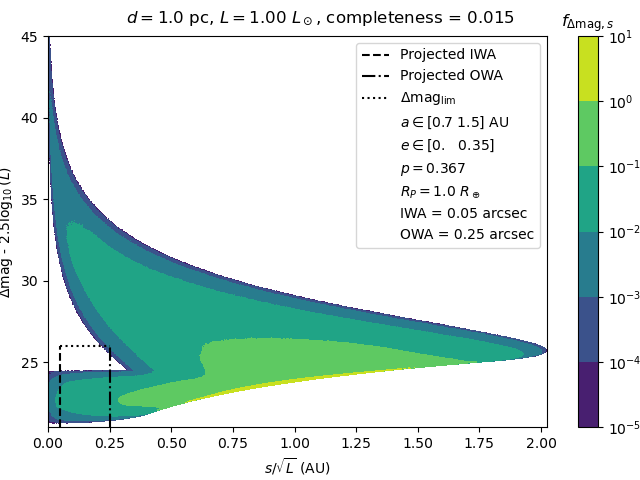

In [9]:
# now changing both d and L
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cs = ax3.contourf(
        TL.Completeness.xnew,
        TL.Completeness.ynew,
        TL.Completeness.Cpdf,
        locator=ticker.LogLocator(),
    )
ax3.set_xlabel("Projected Separation (AU)")
ax3.set_ylabel("$\Delta$mag")
ax3.set_xlabel("$s/\sqrt{L}$ (AU)")
ax3.set_ylabel("$\Delta$mag - 2.5$\log_{10}(L)$")
cbar = fig.colorbar(cs)
cbar.ax.set_title("$f_{\Delta\\mathrm{mag},s}$")
ax3.set_ylim(ylim)
plt.subplots_adjust(top=0.925, left=0.075, right=1.05)
pIWA3 = ax3.plot([1] * 2, [ylim[0], 26], "k--", label="Projected IWA")[0]
pOWA3 = ax3.plot([1.5] * 2, [ylim[0],26], "k-.", label="Projected OWA")[0]
dmaglim3 = ax3.plot(
    [1, 1.5], [26] * 2, "k:", label="$\\Delta$mag$_\\mathrm{lim}$"
)[0]
ax3.plot(0, 0, label=f"$a \in ${TL.PlanetPopulation.arange}", visible=False)
ax3.plot(0, 0, label=f"$e \in ${TL.PlanetPopulation.erange}", visible=False)
ax3.plot(0, 0, label=f"$p = ${TL.PlanetPopulation.prange[0]}", visible=False)
ax3.plot(
    0,
    0,
    label=f"$R_P = ${TL.PlanetPopulation.Rprange[0].value} $R_\\oplus$",
    visible=False,
)
ax3.plot(0, 0, label=f"IWA = {TL.OpticalSystem.IWA}", visible=False)
ax3.plot(0, 0, label=f"OWA = {TL.OpticalSystem.OWA}", visible=False)
ax3.legend(loc=1)
ax3.set_ylim(ylim)
fig3.suptitle(f"$d = 1$, $L = 1$, completeness = 0.5");


def drawCompFrame3(d, L):
    smn = (np.tan(mode["IWA"]) * d*u.pc).to(u.AU) / np.sqrt(L)
    smx = (np.tan(mode["OWA"]) * d*u.pc).to(u.AU) / np.sqrt(L)
    dmg = 26 - 2.5 * np.log10(L)
    comp = TL.Completeness.comp_calc(smn.value, smx.value, dmg)
    
    pIWA3.set_data([smn.value] * 2, [ylim[0], dmg])
    pOWA3.set_data([smx.value] * 2, [ylim[0], dmg])
    dmaglim3.set_data([smn.value, smx.value], [dmg] * 2)
    if smx.value > TL.Completeness.xnew.max():
        ax3.set_xlim([0, np.ceil(smx.value*10)/10])
    else:
        ax3.set_xlim([0,TL.Completeness.xnew.max()])
    fig3.suptitle(f"$d = ${d :.1f} pc, $L = ${L :.2f} $L_\odot$, completeness = {comp :.3f}")


widgets.interact(drawCompFrame3, 
                 d=widgets.FloatSlider(
                     value=1,
                     min=1,
                     max=30.0,
                     step=0.1,
                     description='$d$ (pc)',
                     readout_format='.1f',
                 ), 
                 L = widgets.FloatLogSlider(
                     value=1,
                     base=10,
                     min=-2, # max exponent of base
                     max=2, # min exponent of base
                     step=0.1, # exponent step
                     description='$L$ ($L_\odot$)',
                     readout_format='.2f',
                 )
);

# use slider to change the star luminosity

We can also explore how integration time impacts completeness:

interactive(children=(IntSlider(value=0, description='j', max=39), Output()), _dom_classes=('widget-interact',…

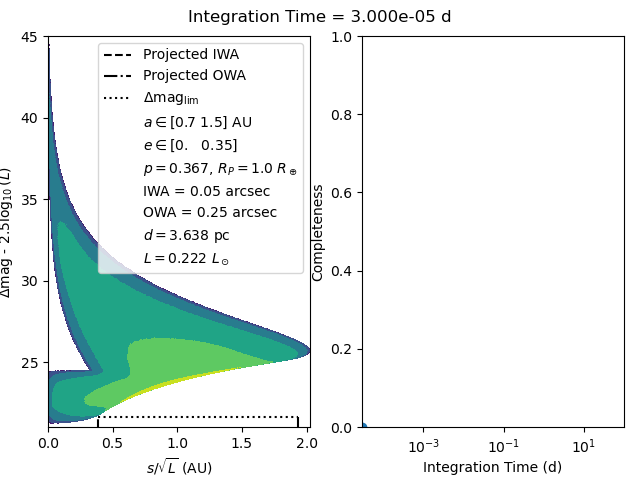

In [10]:
sInd = np.argmax(TL.saturation_comp)
intTimes = np.logspace(np.log10(3e-5), np.log10(100), 40)*u.d

sInds = np.array([sInd] * len(intTimes))
fZ = [TL.ZodiacalLight.fZ0.value] * len(intTimes) * TL.ZodiacalLight.fZ0.unit
fEZ = [TL.ZodiacalLight.fEZ0.value] * len(intTimes) * TL.ZodiacalLight.fEZ0.unit
mode = TL.OpticalSystem.observingModes[0]
WAs = [TL.int_WA[sInd].value] * len(sInds) * TL.int_WA.unit

dMags = TL.OpticalSystem.calc_dMag_per_intTime(
    intTimes, TL, sInds, fZ, fEZ, WAs, mode
)

smins4 = (np.tan(mode["IWA"]) * TL.dist[sInd]).to(u.AU) / np.sqrt(TL.L[sInd])
smaxs4 = (np.tan(mode["OWA"]) * TL.dist[sInd]).to(u.AU) / np.sqrt(TL.L[sInd])
dmags4 = dMags - 2.5 * np.log10(TL.L[sInd])
comps4 = TL.Completeness.comp_calc(smins4.value, smaxs4.value, dmags4)

fig4, axs4 = plt.subplots(1, 2)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cs = axs4[0].contourf(
        TL.Completeness.xnew,
        TL.Completeness.ynew,
        TL.Completeness.Cpdf,
        locator=ticker.LogLocator(),
    )
axs4[0].set_xlabel("$s/\sqrt{L}$ (AU)")
axs4[0].set_ylabel("$\Delta$mag - 2.5$\log_{10}(L)$")
pIWA4 = axs4[0].plot([smins4.value] * 2, [ylim[0], dmags4[0]], "k--", label="Projected IWA")[0]
pOWA4 = axs4[0].plot([smaxs4.value] * 2, [ylim[0], dmags4[0]], "k-.", label="Projected OWA")[0]
dmaglim4 = axs4[0].plot(
    [smins4.value, smaxs4.value], [dmags4[0]] * 2, "k:", label="$\\Delta$mag$_\\mathrm{lim}$"
)[0]
axs4[0].plot(0, 0, label=f"$a \in ${TL.PlanetPopulation.arange}", visible=False)
axs4[0].plot(0, 0, label=f"$e \in ${TL.PlanetPopulation.erange}", visible=False)
axs4[0].plot(0, 0, label=f"$p = ${TL.PlanetPopulation.prange[0]}, $R_P = ${TL.PlanetPopulation.Rprange[0].value} $R_\\oplus$", visible=False)
axs4[0].plot(0, 0, label=f"IWA = {TL.OpticalSystem.IWA}", visible=False)
axs4[0].plot(0, 0, label=f"OWA = {TL.OpticalSystem.OWA}", visible=False)
axs4[0].plot(0, 0, label=f"$d = ${TL.dist[sInd] :.3f}", visible=False)
axs4[0].plot(0, 0, label=f"$L = ${TL.L[sInd] :.3f} $L_\\odot$", visible=False)
axs4[0].legend(loc=1)
axs4[0].set_ylim(ylim)
fig4.suptitle(f"Integration Time = {intTimes[0] :.3e}")

compline4 = axs4[1].semilogx(intTimes[0], comps4[0])[0]
comppoint4 = axs4[1].scatter(intTimes[0], comps4[0])
axs4[1].set_xlim([np.min(intTimes.value), np.max(intTimes.value)])
axs4[1].set_ylim([0, 1])
axs4[1].set_xlabel("Integration Time (d)")
axs4[1].set_ylabel("Completeness")

plt.subplots_adjust(top=0.925, left=0.075, right=0.975)

def drawCompFrame4(j):
    pIWA4.set_data([smins4.value] * 2, [ylim[0], dmags4[j]])
    pOWA4.set_data([smaxs4.value] * 2, [ylim[0], dmags4[j]])
    dmaglim4.set_data([smins4.value, smaxs4.value], [dmags4[j]] * 2)
    fig4.suptitle(f"Integration Time = {intTimes[j] :.3e}")
    compline4.set_data(intTimes[: j + 1].value, comps4[: j + 1])
    comppoint4.set_offsets((intTimes[j].value, comps4[j]))

widgets.interact(drawCompFrame4, j=widgets.IntSlider(min=0, max=len(intTimes)-1, step=1, value=0));
# use slider to change the integration time
